<a href="https://colab.research.google.com/github/VukIG/Segmetacija-Koronarnih-Arterija/blob/main/vessel_branch_classification_unstable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import json
import cv2
import os
import tensorflow as tf
from google.colab import drive


In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

with open(r"/content/drive/MyDrive/syntax/syntax/test/annotations/test.json", "r") as f:
    data = json.load(f)


How big are the top level fields

In [ ]:
print(len(data["categories"]))
print(len(data["annotations"]))
print(len(data["images"]))

26
1672
300


Insight into their structure

In [ ]:
print(data["categories"])
print(data["annotations"][0])
print(data["images"][0])

[{'id': 1, 'name': '1', 'supercategory': ''}, {'id': 2, 'name': '2', 'supercategory': ''}, {'id': 3, 'name': '3', 'supercategory': ''}, {'id': 4, 'name': '4', 'supercategory': ''}, {'id': 5, 'name': '5', 'supercategory': ''}, {'id': 6, 'name': '6', 'supercategory': ''}, {'id': 7, 'name': '7', 'supercategory': ''}, {'id': 8, 'name': '8', 'supercategory': ''}, {'id': 9, 'name': '9', 'supercategory': ''}, {'id': 10, 'name': '9a', 'supercategory': ''}, {'id': 11, 'name': '10', 'supercategory': ''}, {'id': 12, 'name': '10a', 'supercategory': ''}, {'id': 13, 'name': '11', 'supercategory': ''}, {'id': 14, 'name': '12', 'supercategory': ''}, {'id': 15, 'name': '12a', 'supercategory': ''}, {'id': 16, 'name': '13', 'supercategory': ''}, {'id': 17, 'name': '14', 'supercategory': ''}, {'id': 18, 'name': '14a', 'supercategory': ''}, {'id': 19, 'name': '15', 'supercategory': ''}, {'id': 20, 'name': '16', 'supercategory': ''}, {'id': 21, 'name': '16a', 'supercategory': ''}, {'id': 22, 'name': '16b', 

In [ ]:
for category in data["categories"]:
    print(category["name"])


1
2
3
4
5
6
7
8
9
9a
10
10a
11
12
12a
13
14
14a
15
16
16a
16b
16c
12b
14b
stenosis


In [ ]:
name_to_color = {
    # RCA
    '1': (255, 0, 0),
    '2': (220, 20, 60),
    '3': (178, 34, 34),
    '4': (139, 0, 0),

    # Posterolateral  RCA
    '16':  (255, 99, 71),
    '16a': (255, 69, 0),
    '16b': (205, 92, 92),
    '16c': (240, 128, 128),

    # Left Main + LAD
    '5': (255, 215, 0),       # Left Main (golden yellow)
    '6': (0, 255, 0),         # LAD proximal
    '7': (34, 139, 34),       # LAD mid
    '8': (0, 128, 0),         # LAD apical

    # Diagonals
    '9':  (0, 191, 255),
    '9a': (30, 144, 255),
    '10': (70, 130, 180),
    '10a':(100, 149, 237),

    # Circumflex / Marginals
    '11': (148, 0, 211),      # Proximal circumflex
    '12': (186, 85, 211),
    '12a':(147, 112, 219),
    '12b':(138, 43, 226),
    '13': (153, 50, 204),

    # Left Posterolaterals + Posterior descending
    '14':  (255, 140, 0),
    '14a': (255, 165, 0),
    '14b': (255, 180, 100),
    '15':  (255, 215, 160),

    # Special case: stenosis
    'stenosis': (255, 255, 255)
}


In [ ]:
images_df = pd.DataFrame(data["images"])
categories_df = pd.DataFrame(data["categories"])
annotations_df = pd.DataFrame(data["annotations"])

In [ ]:
print(images_df.info())
print(categories_df.info())
print(annotations_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             300 non-null    int64 
 1   width          300 non-null    int64 
 2   height         300 non-null    int64 
 3   file_name      300 non-null    object
 4   license        300 non-null    int64 
 5   flickr_url     300 non-null    object
 6   coco_url       300 non-null    object
 7   date_captured  300 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 18.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26 non-null     int64 
 1   name           26 non-null     object
 2   supercategory  26 non-null     object
dtypes: int64(1), object(2)
memory usage: 756.0+ bytes
None
<class 'pandas.core.frame.DataFra

In [ ]:
sample_id = 1
segmentations = annotations_df[annotations_df["image_id"]==sample_id]
categories_df["color"] = categories_df["name"].map(name_to_color)
print(segmentations)


   id  image_id  category_id  \
0   1         1           18   
1   2         1            5   
2   3         1           17   
3   4         1           25   
4   5         1           13   
5   6         1           16   

                                        segmentation    area  \
0  [[252.3, 288.21, 257.7, 289.21, 261.5, 291.81,...  1373.0   
1  [[151.59, 207.74, 153.21, 206.12, 154.99, 204....   956.0   
2  [[254.1, 259.41, 257.5, 259.41, 260.1, 260.01,...   428.0   
3  [[223.6, 393.7, 229.18, 395.39, 231.0, 396.6, ...  2270.0   
4  [[188.8, 156.5, 195.9, 156.2, 201.1, 155.6, 20...  1015.0   
5  [[244.42, 210.1, 243.1, 219.4, 243.6, 227.8, 2...  1888.0   

                             bbox  iscrowd           attributes  
0   [252.3, 288.21, 169.6, 102.8]        0  {'occluded': False}  
1   [142.74, 157.1, 49.58, 50.64]        0  {'occluded': False}  
2   [253.54, 259.41, 56.76, 65.0]        0  {'occluded': False}  
3  [218.08, 354.2, 234.82, 79.26]        0  {'occluded': False

In [ ]:
masked_image = np.zeros((512,512,3))

for index, row in segmentations.iterrows():
    category_id = row["category_id"]
    segmentation_verticies = np.array(row["segmentation"][0]).reshape(-1,2)
    segmentation_label = categories_df[categories_df["id"]==category_id]["name"].iloc[0]
    color = categories_df[categories_df["id"]==category_id]["color"].iloc[0]
    bbox = row["bbox"]
    cv2.fillPoly(masked_image, pts=[segmentation_verticies.astype(np.int32)], color=color)


Representations of the original image and the segmented one

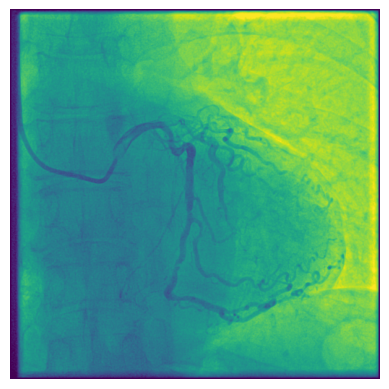

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_image_path = r"/content/drive/MyDrive/syntax/syntax/test/images/1.png"
image = mpimg.imread(original_image_path)

plt.imshow(image)
plt.axis('off')
plt.show()


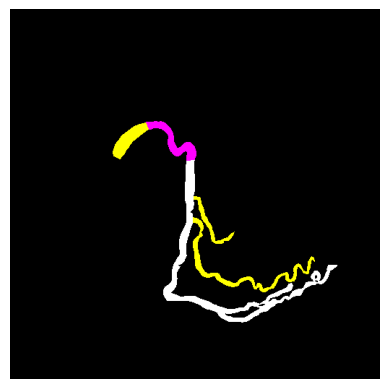

True

In [ ]:
plt.imshow(masked_image)

plt.axis('off')  # optional
plt.show()
cv2.imwrite("prvaSlika.png",masked_image)

In [ ]:
def gnerate_full_27c_mask(sample_id, destination_directory,annon_df,cat_df):
    segs = annon_df[annon_df["image_id"]==sample_id]
    masked_image = np.zeros((512, 512), dtype=np.uint8)

    for _, row in segs.iterrows():
        category_id = row["category_id"]
        segmentation_verticies = np.array(row["segmentation"][0]).reshape(-1,2)
        color = cat_df[cat_df["id"]==category_id]["color"].iloc[0]
        cv2.fillPoly(masked_image, pts=[segmentation_verticies.astype(np.int32)], color=color)

    output_path = os.path.join(destination_directory, str(sample_id) + ".png")
    cv2.imwrite(output_path,masked_image)


In [ ]:
def generate_binary_mask(sample_id, destination_directory,annon_df,cat_df):
    segs = annon_df[annon_df["image_id"]==sample_id]
    masked_image = np.zeros((512, 512, 3), dtype=np.uint8)

    for _, row in segs.iterrows():
        category_id = row["category_id"]
        segmentation_verticies = np.array(row["segmentation"][0]).reshape(-1,2)
        id_of_segmentation = cat_df[cat_df["id"]==category_id]["id"].iloc[0]
        print(id_of_segmentation)
        if(id_of_segmentation==26):
            color=(255,0,0)
        else:
            color = (255,255,255)
        cv2.fillPoly(masked_image, pts=[segmentation_verticies.astype(np.int32)], color=color)

    output_path = os.path.join(destination_directory, str(sample_id) + ".png")
    cv2.imwrite(output_path,masked_image)


In [ ]:
syntax_folder = r"/content/drive/MyDrive/syntax/syntax/"


with open(r"/content/drive/MyDrive/syntax/syntax/train/annotations/train.json","r") as f:
        train_data = json.load(f)

with open(r"/content/drive/MyDrive/syntax/syntax/test/annotations/test.json","r") as f:
        test_data = json.load(f)


with open(r"/content/drive/MyDrive/syntax/syntax/val/annotations/val.json","r") as f:
        validate_data = json.load(f)


for subfolder in os.listdir(syntax_folder):
    subfolder_path = os.path.join(syntax_folder, subfolder)
    dest_dir = os.path.join(syntax_folder, subfolder_path, "binary_mask")
    images_dir = os.path.join(subfolder_path, "images")
    annotation_filename = f"{subfolder}.json"
    annotationJSON = os.path.join(subfolder_path,"annotations",annotation_filename) # Bug when using open additional backslashes added between folders pls help me
    os.makedirs(dest_dir, exist_ok=True)

    if(subfolder=="train"):
        data = train_data
    elif(subfolder=="test"):
        data = test_data
    else:
        data = validate_data

    cat_df = pd.DataFrame(data["categories"])
    cat_df["color"] = cat_df["name"].map(name_to_color)
    annon_df = pd.DataFrame(data["annotations"])

    for filename in os.listdir(images_dir):
        image_id = int(os.path.splitext(filename)[0])
        generate_binary_mask(image_id,dest_dir,annon_df, cat_df)

Streaming output truncated to the last 5000 lines.
8
10
7
5
6
24
6
13
5
4
20
2
3
1
2
20
3
1
4
6
9
7
13
5
8
17
6
16
15
13
5
19
8
5
6
7
13
16
5
9
18
7
17
6
9
16
5
6
25
13
13
16
6
5
3
1
2
4
20
8
7
5
6
5
17
25
16
6
14
13
3
4
2
20
1
15
13
16
5
25
1
2
3
6
7
8
11
7
5
8
6
3
2
1
4
20
1
3
2
7
9
6
8
5
5
7
8
6
6
7
7
5
6
6
5
7
16
13
6
5
15
6
5
16
17
13
9
8
7
5
6
8
6
5
7
2
3
1
4
4
1
3
2
20
4
20
2
3
1
6
10
11
7
8
5
16
25
14
5
6
15
13
8
7
6
9
5
10
13
11
6
13
17
15
5
25
14
16
13
15
17
18
16
25
3
1
20
2
4
16
25
13
5
4
1
2
20
3
5
13
16
9
8
6
5
7
6
25
16
17
5
13
19
16
5
15
13
7
5
8
6
20
4
3
1
2
16
25
13
15
5
8
7
6
15
5
6
24
16
13
9
8
5
6
7
16
18
13
19
15
25
10
5
8
7
6
3
4
2
1
20
14
6
9
7
5
8
3
2
4
1
5
7
8
10
6
5
15
24
19
16
13
6
5
7
5
6
7
8
5
9
7
8
6
4
3
2
1
2
3
1
9
6
5
8
7
4
1
20
2
3
2
4
20
1
3
1
2
3
4
20
3
4
20
2
21
1
20
2
3
1
4
1
2
4
3
20
11
8
9
6
7
5
4
20
3
2
1
4
20
2
1
3
4
20
3
2
1
1
2
3
4
10
8
14
9
5
6
7
1
3
2
8
6
9
5
7
5
6
16
13
14
1
20
2
3
4
5
11
7
6
8
16
6
13
24
20
2
1
4
22
3
1
3
2
4
7
15
13
16
2

Pre processing step

In [5]:
import numpy as np
import cv2
from skimage import morphology
import argparse


def improve_contrast(source):
    # Ensure input is HWC
    if source.shape[-1] == 3:
        img = source[:, :, 0]  # Use red channel
    else:
        img = source  # Already grayscale

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_not = cv2.bitwise_not(img)
    se = np.ones((50, 50), np.uint8)
    wth = morphology.white_tophat(img_not, se)

    raw_minus_topwhite = img.astype(np.int16) - wth
    raw_minus_topwhite = np.clip(raw_minus_topwhite, 0, 255).astype(np.uint8)

    img = clahe.apply(raw_minus_topwhite)

    img = img[:, :, np.newaxis]  # (H, W, 1)
    d3 = np.concatenate([img, img, img], axis=2).astype(np.uint8)  # (H, W, 3)

    return d3


for subfolder in os.listdir(syntax_folder):
    subfolder_path = os.path.join(syntax_folder, subfolder)
    dest_dir = os.path.join(syntax_folder, subfolder_path, "sharpened_images")
    images_dir = os.path.join(subfolder_path, "images")
    os.makedirs(dest_dir, exist_ok=True)
    for filename in os.listdir(images_dir):
      image_path = os.path.join(images_dir, filename)

      img_np = cv2.imread(image_path)
      improved_image = improve_contrast(img_np)
      output_path = os.path.join(dest_dir, filename)
      cv2.imwrite(output_path,improved_image)


NameError: name 'syntax_folder' is not defined

In [5]:
train_x = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/syntax/syntax/train/sharpened_images",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    batch_size=32,
    color_mode="grayscale"
)

test_x = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/syntax/syntax/test/sharpened_images",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    color_mode="grayscale",
    batch_size=32
)

validate_x = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/syntax/syntax/val/sharpened_images",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    batch_size=32,
    color_mode="grayscale"
)

train_y = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/syntax/syntax/train/binary_mask",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    batch_size=32,
    color_mode="grayscale"
)

validate_y = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/syntax/syntax/val/binary_mask",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    batch_size=32,
    color_mode="grayscale"
)

test_y = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/syntax/syntax/test/binary_mask",
    labels=None,
    class_names=None,
    image_size=(512,512),
    shuffle=False,
    color_mode="grayscale",
    batch_size=32
)


Found 1000 files.
Found 300 files.
Found 200 files.
Found 1000 files.
Found 200 files.
Found 300 files.


In [6]:
train_dataset = tf.data.Dataset.zip((train_x, train_y))
test_dataset = tf.data.Dataset.zip((test_x, test_y))
validate_dataset = tf.data.Dataset.zip((validate_x, validate_y))

In [7]:
print(train_x.take(1))

<_TakeDataset element_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None)>


In [8]:
print(train_y.take(1))
print(train_y)

<_TakeDataset element_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None)>
<_PrefetchDataset element_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None)>


In [9]:
print(train_dataset)
print(validate_dataset)

<_ZipDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>
<_ZipDataset element_spec=(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>


In [7]:
def normalize_dataset(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


train_dataset = train_dataset.map(normalize_dataset)
test_dataset = test_dataset.map(normalize_dataset)
validate_dataset = validate_dataset.map(normalize_dataset)

Defining the U-Net model    

In [8]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, SeparableConv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation, MaxPooling2D, concatenate


def conv_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0.1):
    conv1 = SeparableConv2D(n_filters,3,padding="same")(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    dropout = tf.keras.layers.Dropout(dropout_prob, noise_shape=None, seed=42)(conv1)
    conv2 = SeparableConv2D(n_filters,3,padding="same")(dropout)
    if batch_norm:
        conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)


    return conv2


def encoder_block(inputs=None, n_filters=64, batch_norm=True, dropout_prob=0.1):
    skip_connection = conv_block(inputs, n_filters, batch_norm, dropout_prob)
    next_layer = MaxPooling2D((2,2))(skip_connection)

    return next_layer, skip_connection

def decoder_block(expansive_input, skip_connection, n_filters, batch_norm=True, dropout_prob=0.1):
    up = Conv2DTranspose(n_filters, 3, strides=2, padding="same")(expansive_input)
    merge = concatenate([up, skip_connection], axis=-1)
    conv = conv_block(merge, n_filters, batch_norm, dropout_prob)
    return conv

def standard_u_net(input_size=(512,512,1), n_filters=2, n_classes=1, batch_norm=True, dropouts=np.random.uniform(0.1, 0.3, size=10)):

    inputs = Input(input_size)
    encoder_block1 = encoder_block(inputs,n_filters,batch_norm,dropout_prob=dropouts[0])
    encoder_block2 = encoder_block(encoder_block1[0],n_filters*2,batch_norm,dropout_prob=dropouts[1])
    encoder_block3 = encoder_block(encoder_block2[0],n_filters*4,batch_norm,dropout_prob=dropouts[2])
    encoder_block4 = encoder_block(encoder_block3[0],n_filters*8,batch_norm,dropout_prob=dropouts[3])
    encoder_block5 = encoder_block(encoder_block4[0],n_filters*16,batch_norm,dropout_prob=dropouts[3])

    bridge = conv_block(encoder_block5[0], n_filters*32, batch_norm, dropout_prob=dropouts[5])

    decoder_block1 = decoder_block(bridge,encoder_block5[1],n_filters*16,batch_norm,dropout_prob=dropouts[0])
    decoder_block2 = decoder_block(decoder_block1,encoder_block4[1],n_filters*8,batch_norm,dropout_prob=dropouts[1])
    decoder_block3 = decoder_block(decoder_block2,encoder_block3[1],n_filters*4,batch_norm,dropout_prob=dropouts[2])
    decoder_block4 = decoder_block(decoder_block3,encoder_block2[1],n_filters*2,batch_norm,dropout_prob=dropouts[3])
    decoder_block4 = decoder_block(decoder_block4,encoder_block1[1],n_filters,batch_norm,dropout_prob=dropouts[3])

    conv10 = Conv2D(n_classes, 1, padding="same")(decoder_block4)
    output = Activation("sigmoid")(conv10)

    model = tf.keras.Model(inputs=inputs, outputs=output, name="Unet")

    return model

In [9]:
def custom_loss(y_true, y_pred):
  binary_loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy'
  )(y_true, y_pred)
  dice_loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size', name='dice'
  )(y_true, y_pred)
  return binary_loss+dice_loss

In [85]:
model = standard_u_net()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss=custom_loss,
    metrics=[
        tf.keras.metrics.BinaryIoU(target_class_ids=(0, 1), threshold=0.5, name=None, dtype=tf.float32),
        "accuracy"
    ]
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
for batch in train_dataset.take(1):
    print(batch[0].shape, batch[1].shape)


(32, 512, 512, 1) (32, 512, 512, 1)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [86]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=30,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
    train_dataset,
    validation_data=validate_dataset,  # no need for extra parentheses
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.2939 - binary_io_u_4: 0.2377 - loss: 2.9869 - val_accuracy: 0.0000e+00 - val_binary_io_u_4: 0.0000e+00 - val_loss: -2.7146
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 220ms/step - accuracy: 0.2941 - binary_io_u_4: 0.2378 - loss: 2.9452 - val_accuracy: 0.0000e+00 - val_binary_io_u_4: 0.0000e+00 - val_loss: -4.7845
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.2943 - binary_io_u_4: 0.2378 - loss: 2.9135 - val_accuracy: 0.0000e+00 - val_binary_io_u_4: 0.0000e+00 - val_loss: -6.1870
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.2944 - binary_io_u_4: 0.2378 - loss: 2.8724 - val_accuracy: 7.9346e-06 - val_binary_io_u_4: 1.2397e-05 - val_loss: -7.1418
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.2946 - binary_io_u_4: 0.2378 - loss: 2.8399 - val_accuracy: 3.4676e-05 - val_binary_io_u_4: 5.4175e-05 - val_loss: -7.7801
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/st

KeyboardInterrupt: 

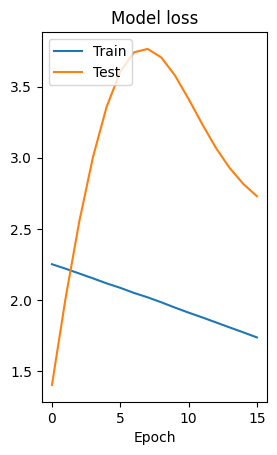

In [81]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test',], loc='upper left')
plt.show()

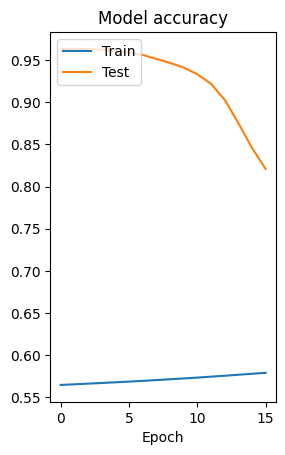

In [83]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test',], loc='upper left')
plt.show()

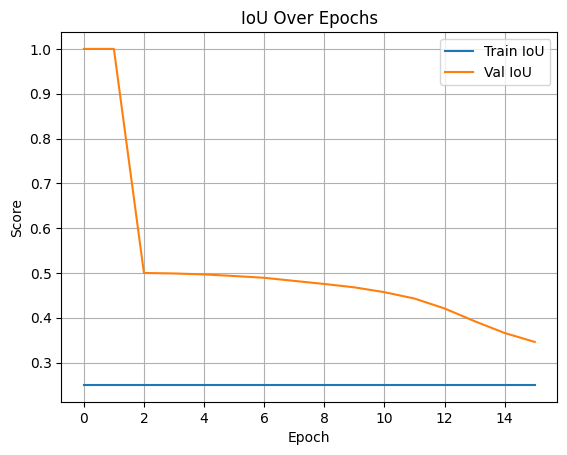

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_io_u'], label='Train IoU')
plt.plot(history.history['val_binary_io_u'], label='Val IoU')


plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('IoU Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [55]:
batch_prediction = model.predict(test_x.take(1))
batch_truth_values = test_y.take(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


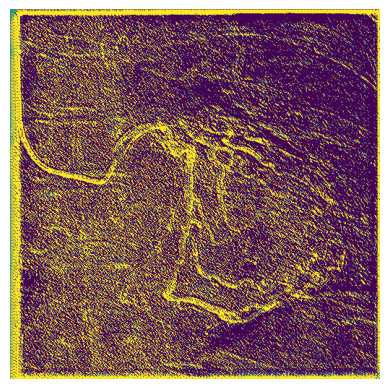

In [84]:
plt.imshow(batch_prediction[0])

plt.axis('off')  # optional
plt.show()


In [57]:
num=1
for batch in batch_truth_values.take(1):
    for image in batch:
        if num==0:
          break
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        num-=1

KeyboardInterrupt: 

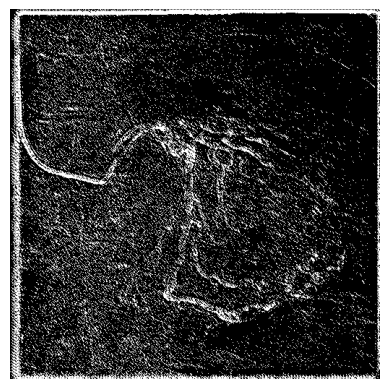

In [74]:
pred = batch_prediction[0]

thresholded = (pred > 0.9999).astype(np.uint8)

# Plot the result
plt.imshow(thresholded, cmap='gray')
plt.axis('off')
plt.show()
